In [1]:
using JLD2, FileIO;
using Quaternions;
using LinearAlgebra;
using Statistics;
using PyPlot;
using JuMP, Ipopt;
using Printf;
using ProgressMeter
include("QRPNN.jl");

In [2]:
function trainRKAM(f,f_params,U,regularizer=1.e3)
    (N,K) = size(U)
    W = zeros(N,K)
    C = f(U'*U/N,f_params);
    for i=1:N
        H = (U[i,:]*U[i,:]').*C;
        model = Model(with_optimizer(Ipopt.Optimizer, print_level=0))
        @variable(model, 0<= x[1:K] <= regularizer);
        @objective(model, Min, dot(x,H*x)/2-dot(ones(K,1),x));
        optimize!(model)
        W[i,:] = JuMP.value.(x).*U[i,:]
    end
    return W
end

trainRKAM (generic function with 2 methods)

In [3]:
N = 100;
K = 36;
tau = 1.e-4;

In [4]:
# Parameters;
it_max = 1.e3;
realf = QRPNN.exponential;

In [5]:
Smax = 100
pr = Array{Float64}(0.0:0.05:1.0)

params = [1,3];
Nparams = length(params)
PrRecall_RKAM = zeros(Int64,(3*Nparams,length(pr)))

@showprogress for s = 1:Smax
    # Generate the fundamental memories
    U = 2.0*rand(Bool,(N,K)).-1.0;

    # Train the projection models
    Vs = []
    for j=1:Nparams
        push!(Vs,QRPNN.train(realf,params[j],U))
    end
    
    # Train the RKAMs models
    Ws = []
    for j=1:Nparams
        push!(Ws,trainRKAM(realf,params[j],U))
    end
    
    for i = 1:length(pr)
        # Generate a corrupted version of a fundamental memory
        x = copy(U[:,1]) .* (1 .- 2*(rand(N,1) .< pr[i]))           
        
        #
        # RKAM
        #
        for j=1:Nparams
            y = QRPNN.main(realf,params[j], U, Ws[j], x, it_max)
            PrRecall_RKAM[j,i] = PrRecall_RKAM[j,i]+(norm(U[:,1]-y)<tau)
        end
        
        #
        # QRCNN
        #
        for j=1:Nparams
            y = QRPNN.main(realf,params[j], U, U, x, it_max)
            PrRecall_RKAM[Nparams+j,i] = PrRecall_RKAM[Nparams+j,i]+(norm(U[:,1]-y)<tau)
        end
        
        #
        # QRPNN
        #
        for j=1:Nparams
            y = QRPNN.main(realf,params[j], U, Vs[j], x, it_max)
            PrRecall_RKAM[2*Nparams+j,i] = PrRecall_RKAM[2*Nparams+j,i]+(norm(U[:,1]-y)<tau)
        end
    end
    @save "JLDs/RKAM_Exponential.jld2" PrRecall_RKAM pr Smax params
end


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



Progress: 100%|█████████████████████████████████████████| Time: 0:01:38


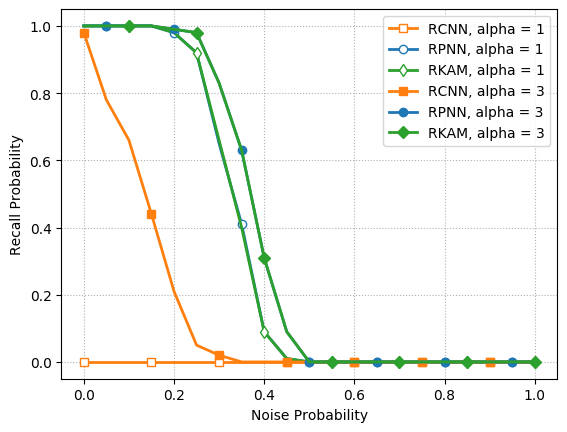

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [6]:
@load "JLDs/RKAM_Exponential.jld2"
Nparams=length(params)
colorlist = ["#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd"]
markerlist = ["<",">","v","o","s"]
j=1    
plot(pr,PrRecall_RKAM[Nparams+j,:]/Smax,color=colorlist[2],linewidth=2,marker="s",markevery=(0,3),mfc="white",label=@sprintf("RCNN, alpha = %d", params[j]))
plot(pr,PrRecall_RKAM[2*Nparams+j,:]/Smax,color=colorlist[1],linewidth=2,marker="o",markevery=(1,3),mfc="white", label=@sprintf("RPNN, alpha = %d", params[j]))
plot(pr,PrRecall_RKAM[j,:]/Smax,linewidth=2,color=colorlist[3],marker="d",markevery=(2,3),mfc="white",label=@sprintf("RKAM, alpha = %d", params[j]))
j=2
plot(pr,PrRecall_RKAM[Nparams+j,:]/Smax,color=colorlist[2],linewidth=2,marker="s",markevery=(0,3),label=@sprintf("RCNN, alpha = %d", params[j]))
plot(pr,PrRecall_RKAM[2*Nparams+j,:]/Smax,color=colorlist[1],linewidth=2,marker="o",markevery=(1,3), label=@sprintf("RPNN, alpha = %d", params[j]))
plot(pr,PrRecall_RKAM[j,:]/Smax,color=colorlist[3],linewidth=2,marker="D",markevery=(2,3),label=@sprintf("RKAM, alpha = %d", params[j]))
grid(linestyle="dotted")
xlabel("Noise Probability")
ylabel("Recall Probability")
legend()
savefig("Figures/RKAM_Exponential.eps")
savefig("Figures/RKAM_Exponential.pdf")

1.208874200436676
0.24494258211173414
0.

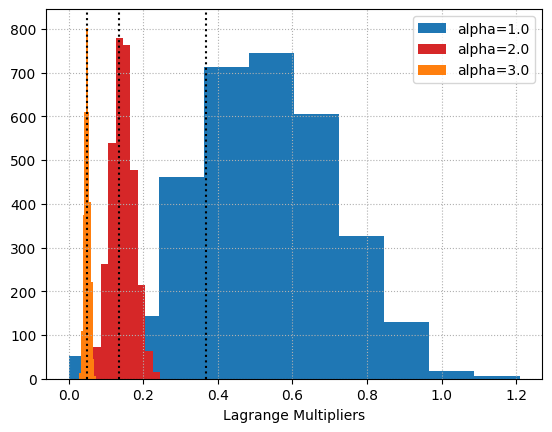

07341548635128321


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [7]:
alphas = [1.0, 2.0, 3.0]
N = 100;
K = 32
alphaH = zeros(N*K,length(alphas))
colorlist = ["#1f77b4","#d62728","#ff7f0e","#2ca02c","#9467bd"]
for j = 1:length(alphas)
    U = 2.0*rand(Bool,(N,K)).-1.0;
    A = zeros(N,K)
    C = realf(U'*U/N,alphas[j]);
    for i=1:N
        H = (U[i,:]*U[i,:]').*C;
        model = Model(with_optimizer(Ipopt.Optimizer, print_level=0))
        @variable(model, 0<= x[1:K]);
        @objective(model, Min, dot(x,H*x)/2-dot(ones(K,1),x));
        optimize!(model)
        A[i,:] = JuMP.value.(x)
    end
    y,x = hist(A[:], label=@sprintf("alpha=%1.1f",alphas[j]),color=colorlist[j]);
    plot(exp(-alphas[j])*[1,1],[0.0, 845.25],color="black",linestyle="dotted")
    println(maximum(A[:]))
#     alphaH[:,j] = A[:]
end
legend()
xlabel("Lagrange Multipliers")
grid(linestyle="dotted")
ylim((0.0, 845.25))
savefig("Figures/RKAM_ExpHist.eps")
savefig("Figures/RKAM_ExpHist.pdf")

In [8]:
pr = Array{Float64}(0.0:0.05:1.0)

alpha = 1
Regularizer = [0.4,0.6,0.8,1.0];
Nparams = length(Regularizer)
PrRecall_RKAMRegularizer = zeros(Int64,(1+Nparams,length(pr)))

@showprogress for s = 1:Smax
    # Generate the fundamental memories
    U = 2.0*rand(Bool,(N,K)).-1.0;

    # Train the projection models
    V = QRPNN.train(realf,alpha,U)
    
    # Train the RKAMs models
    Ws = []
    for j=1:Nparams
        push!(Ws,trainRKAM(realf,alpha,U,Regularizer[j]))
    end
    
    for i = 1:length(pr)
        # Generate a corrupted version of a fundamental memory
        x = copy(U[:,1]) .* (1 .- 2*(rand(N,1) .< pr[i]))           
        
        #
        # RKAM
        #
        for j=1:Nparams
            y = QRPNN.main(realf,alpha, U, Ws[j], x, it_max)
            PrRecall_RKAMRegularizer[1+j,i] = PrRecall_RKAMRegularizer[1+j,i]+(norm(U[:,1]-y)<tau)
        end
        
        #
        # QRPNN
        #
        y = QRPNN.main(realf,alpha, U, V, x, it_max)
        PrRecall_RKAMRegularizer[1,i] = PrRecall_RKAMRegularizer[1,i]+(norm(U[:,1]-y)<tau)
    end
    @save "JLDs/RKAM_ExpRegularizer.jld2" PrRecall_RKAMRegularizer Regularizer pr Smax
end

Progress: 100%|█████████████████████████████████████████| Time: 0:02:31


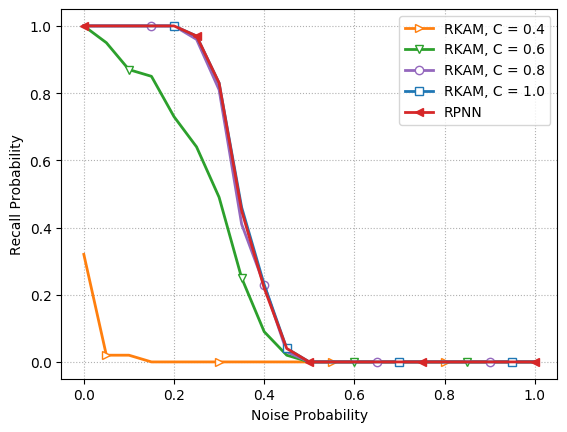

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [9]:
@load "JLDs/RKAM_ExpRegularizer.jld2"
Nparams=length(Regularizer)
colorlist = ["#d62728","#ff7f0e","#2ca02c","#9467bd","#1f77b4"]
markerlist = ["<",">","v","o","s"]
for j=1:Nparams
    plot(pr,PrRecall_RKAMRegularizer[1+j,:]/Smax,linewidth=2,color=colorlist[j+1],marker=markerlist[j+1],markevery=(j,5),mfc="white",label=@sprintf("RKAM, C = %2.1f", Regularizer[j]))
end
plot(pr,PrRecall_RKAMRegularizer[1,:]/Smax,linewidth=2,color=colorlist[1],marker=markerlist[1],markevery=(0,5),label="RPNN")
grid(linestyle="dotted")
xlabel("Noise Probability")
ylabel("Recall Probability")
legend()
savefig("Figures/RKAM_ExpRegularizer.eps")
savefig("Figures/RKAM_ExpRegularizer.pdf")